### Includes

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from sklearn.metrics import f1_score, accuracy_score

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import openpyxl
from tqdm.notebook import tqdm_notebook as tqdm

c:\Users\SHUBHAM\anaconda3\envs\pytorch\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### DATA

In [16]:
def get_excel_sheet_names(file_path):
    workbook = openpyxl.load_workbook(file_path)
    sheet_names = workbook.sheetnames
    return sheet_names

In [89]:
excel_file_path = './data/data_not_fraud.xlsx'
sheet_names = get_excel_sheet_names(excel_file_path)

print(sheet_names)

['TCS', 'tatasteel', 'sbi', 'hdfc']


In [90]:
df = pd.read_excel(excel_file_path, sheet_name=sheet_names, index_col=0)
df.keys()

dict_keys(['TCS', 'tatasteel', 'sbi', 'hdfc'])

In [92]:
df['TCS'].head()

,FY 2004,FY 2005,FY 2006,FY 2007,FY 2008,FY 2009,FY 2010,FY 2011,FY 2012,FY 2013,FY 2014,FY 2015,FY 2016,FY 2017,FY 2018,FY 2019,FY 2020,FY 2021,FY 2022,FY 2023
Return on Common Equity,95.184,71.3497,63.7212,57.3764,47.7519,37.7569,41.1039,42.3425,38.5566,40.8529,40.7257,37.4676,39.112,32.5552,29.422,35.2042,36.8165,37.5606,43.1382,46.3967
Return on Assets,46.5594,43.7576,44.7078,39.8019,32.688,26.1496,27.9849,30.1889,28.1402,29.7702,31.5771,27.8484,29.374,26.7483,24.1633,27.9178,27.182,25.5576,27.9356,29.3418
Return on Capital,—,60.6551,59.9417,—,—,36.1322,40.0612,41.8999,38.1187,40.4177,40.4203,37.1425,38.6997,32.4178,29.3107,35.2436,35.4373,34.7839,39.7004,43.1679
Return on Invested Capital,63.7795,66.5849,57.0539,50.4883,39.4505,38.636,39.2046,38.7909,36.6872,37.7001,38.1678,32.4788,35.2564,28.7653,26.3791,31.5624,30.9993,30.9908,34.1824,36.8829
Gross Margin,45.896,—,—,—,—,—,—,—,—,—,47.36,—,43.9464,43.2998,42.0912,41.857,—,40.8334,—,39.5595


In [2]:
fpath = './data_not_fraud.xlsx'
window_size = 3  

In [6]:
X = torch.Tensor()
y = torch.Tensor()

### Data

In [9]:
def impute_missing_values(data):
    data.replace('—', pd.NA, inplace=True)
    data = data.apply(pd.to_numeric, errors='coerce')
    data = data.ffill(axis=1)
    data.fillna(0, inplace=True)

    return data

def create_time_series_df(file_path, window_size, label_type=1):
    Xs = torch.Tensor()
    ys = torch.Tensor()

    if(label_type == 1):
        ys = torch.Tensor(np.array([
            0,0,0,0,0,1,1,1,0,0, 
            0,0,0,0,0,0,0,0,0,0,0,0,0,1,
            0,0,0,0,1,1,1,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,1,1,
            0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,
            0,0,0,0,0,0,0,1,1,1,0,0,0
        ]))
        

    excel_file = pd.ExcelFile(file_path)

    for sheet_name in excel_file.sheet_names:
        company_data = pd.read_excel(excel_file, sheet_name, index_col=0)

        company_data = impute_missing_values(company_data)
        company_data = company_data.T

        d = company_data.to_numpy()

        ret = []
        l = []

        for i in range(d.shape[0] - window_size + 1):
            ret.append(d[i:i+window_size])

            if(label_type == 0):
                l.append(label_type)

        Xs = torch.concat([Xs, torch.Tensor(np.array(ret))], dim=0)

        if(label_type == 0):
            ys = torch.concat([ys, torch.Tensor(np.array(l))], dim=0)


    return Xs, ys

fpath = "./data_not_fraud.xlsx"
Xs, ys = create_time_series_df(fpath, window_size, 0)
Xs.shape, ys.shape

(torch.Size([70, 3, 21]), torch.Size([70]))

In [11]:
# X = torch.concat([X, Xs], dim=0)
# y = torch.concat([y, ys], dim=0)

# print(X.size(0))

indices = torch.randperm(X.size(0))

X = X[indices]
y = y[indices]

X.shape, y.shape

(torch.Size([147, 3, 21]), torch.Size([147]))

In [12]:
X_train = X[:120]
y_train = y[:120]

X_test = X[120:]
y_test = y[120:]

In [13]:
input_size = 21
hidden_size = 64
output_size = 1
num_layers = 1
num_epochs = 1000
learning_rate = 0.001

### Models

#### GRU

In [14]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

model = GRUModel(input_size, hidden_size, output_size, num_layers)

In [15]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
train_loss_list = []

In [17]:
for epoch in tqdm(range(num_epochs)):
    # Forward pass
    outputs = model(X_train)

    # Compute loss
    loss = criterion(outputs.squeeze(), y_train.float())

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print some information about the training progress
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    train_loss_list.append(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [100/1000], Loss: 0.1078
Epoch [200/1000], Loss: 0.0660
Epoch [300/1000], Loss: 0.0433
Epoch [400/1000], Loss: 0.0293
Epoch [500/1000], Loss: 0.0197
Epoch [600/1000], Loss: 0.0144
Epoch [700/1000], Loss: 0.0108
Epoch [800/1000], Loss: 0.0085
Epoch [900/1000], Loss: 0.0070
Epoch [1000/1000], Loss: 0.0053


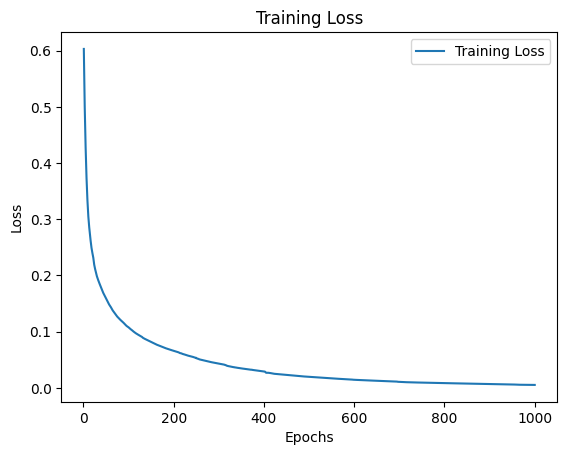

In [18]:
plt.plot(range(1, num_epochs+1), train_loss_list, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [1]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).float()

# Convert predictions and true labels to numpy arrays
y_pred_np = y_pred_binary.cpu().numpy()
y_test_np = y_test.cpu().numpy()

# Calculate F1 score
f1 = f1_score(y_test_np, y_pred_np)
ac = accuracy_score(y_test_np, y_pred_np) * 100.0

print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {ac: .2f}%')

F1 Score: 0.8947
Accuracy:  96.30%


In [20]:
y_test_np

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

#### Attention